In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import numpy as np 
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
import PIL.Image
from tensorflow.keras import backend as K
import cv2
import segmentation_models as sm
from IPython import display
import copy
from skimage.color import rgb2gray
import random
import gc



2024-04-03 22:07:53.588530: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 22:07:53.611602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 22:07:53.611628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 22:07:53.612470: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 22:07:53.616897: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `keras` framework.


In [2]:
N_IMAGES=5000

In [3]:
img_path=r'/home/bhavik/Desktop/Pratik/brats_dataset/images/brats2020flair/'
mask_path=r'/home/bhavik/Desktop/Pratik/brats_dataset/masks/brats2020mask/'

In [4]:
images=[]
masks=[]

In [5]:
# def get_images(img_path=img_path,mask_path=mask_path,number=5000,threshold=0.01):
#     #storing 5000 images and masks in the lists images and masks. Only storing those images in which masked region is greater than 1% 
#     #and combining different mask calsses into one
#     images=[]
#     masks=[]
#     grays=[]
#     for root, dirs, files in os.walk(img_path,mask_path):
#         print(len(files))
#         for i,name in enumerate(files):
#             image_path = img_path+name
#             msk_path=mask_path+name.replace("flair","seg")
#             try:
#                 image = PIL.Image.open(image_path)
#                 mask=PIL.Image.open(msk_path)
#                 # Convert the mask to grayscale.
#                 gray_mask = np.mean(mask.convert('RGB'), axis=2)
#                 # Resize the mask to 240x240x1.
                
#                 resized_mask = np.resize(gray_mask, (240, 240,1))
#                 val, counts = np.unique(resized_mask, return_counts=True)
#                 if (1 - (counts[0]/counts.sum())) > threshold:
#                     images.append(np.array(image.convert('RGB'))/255)
#                     masks.append(np.array(resized_mask)/255)
#                     grays.append(rgb2gray(np.array(image.convert('RGB'))/255))
#             except:
#                 continue
#             if len(images)==number-1:
#                 break
#     images_array=np.array(images)
#     masks_array=np.array(masks)
#     bw_images_array=np.array(grays)
#     unique_values=np.unique(masks_array[:100])
#     masks_array[masks_array==unique_values[1]]=1
#     masks_array[masks_array==unique_values[2]]=1

#     del images,masks
#     return images_array,masks_array,bw_images_array

In [6]:
def get_images(img_path=img_path,mask_path=mask_path,number=5000,threshold=0.1,patient_number_lower=00,patient_number_higher=300):
    #storing 5000 images and masks in the lists images and masks. Only storing those images in which masked region is greater than 1% 
    #and combining different mask calsses into one
    images=[]
    masks=[]
    grays=[]
    for root, dirs, files in os.walk(img_path,mask_path):
        print(len(files))
        for i,name in enumerate(files):
            image_path = img_path+name
            msk_path=mask_path+name.replace("flair","seg")
            if patient_number_lower<=int(image_path.split("flair")[1][-3:])<=patient_number_higher:
                try:
                    image = PIL.Image.open(image_path)
                    mask=PIL.Image.open(msk_path)
                    # Convert the mask to grayscale.
                    gray_mask = np.mean(mask.convert('RGB'), axis=2)
                    # Resize the mask to 240x240x1.
                    
                    resized_mask = np.resize(gray_mask, (240, 240,1))
                    val, counts = np.unique(resized_mask, return_counts=True)
                    if (1 - (counts[0]/counts.sum())) > threshold:
                        images.append(np.array(image.convert('RGB'))/255)
                        masks.append(np.array(resized_mask)/255)
                        grays.append(rgb2gray(np.array(image.convert('RGB'))/255))
                except:
                    continue
                if len(images)==number-1:
                    break
            else:
                continue
    images_array=np.array(images)
    masks_array=np.array(masks)
    bw_images_array=np.array(grays)
    unique_values=np.unique(masks_array[:100])
    masks_array[masks_array==unique_values[1]]=1
    masks_array[masks_array==unique_values[2]]=1

    del images,masks
    return images_array,masks_array,bw_images_array

In [7]:
images_array, masks_array,bw_images_array=get_images(img_path=img_path,mask_path=mask_path,number=251,threshold=0.05,patient_number_lower=00,patient_number_higher=200)

57196


In [8]:
test_images_array, test_masks_array,test_bw_images_array=get_images(img_path=img_path,mask_path=mask_path,number=51,threshold=0.01,patient_number_lower=201,patient_number_higher=350)

57196


In [9]:
val, counts = np.unique(masks_array[0], return_counts=True)
print(val)
print(counts)

[0. 1.]
[54704  2896]


In [10]:
#converting mask class to one hot encoded vector
from keras.utils import to_categorical
masks_cat = to_categorical(masks_array, num_classes=2)
test_masks_cat = to_categorical(test_masks_array, num_classes=2)

print(masks_cat.shape)
print(test_masks_cat.shape)

(250, 240, 240, 2)
(50, 240, 240, 2)


In [11]:
X_train=images_array
y_train=masks_cat
bw_train=bw_images_array
X_test=test_images_array
y_test=test_masks_cat
bw_test=test_bw_images_array

In [12]:
IMG_HEIGHT = images_array.shape[1]
IMG_WIDTH  = images_array.shape[2]
IMG_CHANNELS = images_array.shape[3]
print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)

240
240
3


In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

kernel_initializer =  'he_uniform'

In [14]:
def multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [15]:
#dice loss
dice_loss = sm.losses.DiceLoss()

In [16]:
unet_model=multi_unet_model(n_classes=2,IMG_HEIGHT=IMG_HEIGHT,IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

2024-04-03 22:08:05.859991: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 22:08:05.880829: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 22:08:05.880949: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=dice_loss,metrics=['accuracy'])

In [18]:
BATCH_SIZE_UNET=2

In [19]:
with tf.device('CPU'):
    X_train_unet=tf.data.Dataset.from_tensor_slices(X_train).batch(BATCH_SIZE_UNET)
    y_train_unet=tf.data.Dataset.from_tensor_slices(tf.cast(y_train,tf.float32)).batch(BATCH_SIZE_UNET)
    final_unet_dataset=tf.data.Dataset.zip((X_train_unet,y_train_unet))
del X_train_unet
del y_train_unet

In [20]:
X_test.shape

(50, 240, 240, 3)

In [21]:
# no. of epoches in range
for _ in range(200):
        for w in final_unet_dataset:
            loss=unet_model.train_on_batch(w[0],w[1],return_dict=True)
        print(loss)

2024-04-03 22:08:07.793638: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-03 22:08:08.015870: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-03 22:08:09.048120: I external/local_xla/xla/service/service.cc:168] XLA service 0x7e90616f26b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-03 22:08:09.048138: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-04-03 22:08:09.051490: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712162289.106577  421698 device_compiler.h:186] Compiled cluster using XLA!

{'loss': 0.5134329795837402, 'accuracy': 0.869383692741394}
{'loss': 0.4982747435569763, 'accuracy': 0.875781238079071}
{'loss': 0.500434160232544, 'accuracy': 0.8805642127990723}
{'loss': 0.49678975343704224, 'accuracy': 0.8749305605888367}
{'loss': 0.4969540238380432, 'accuracy': 0.8714149594306946}
{'loss': 0.49495357275009155, 'accuracy': 0.8773784637451172}
{'loss': 0.4938884973526001, 'accuracy': 0.8805902600288391}
{'loss': 0.4951087236404419, 'accuracy': 0.8807117938995361}
{'loss': 0.49222368001937866, 'accuracy': 0.8782031536102295}
{'loss': 0.4825930595397949, 'accuracy': 0.8893923759460449}
{'loss': 0.4696134924888611, 'accuracy': 0.9063802361488342}
{'loss': 0.4387120008468628, 'accuracy': 0.9180294871330261}
{'loss': 0.39824873208999634, 'accuracy': 0.9163194298744202}
{'loss': 0.33712780475616455, 'accuracy': 0.9331510663032532}
{'loss': 0.28003352880477905, 'accuracy': 0.9314669966697693}
{'loss': 0.23210710287094116, 'accuracy': 0.9508854150772095}
{'loss': 0.234632611

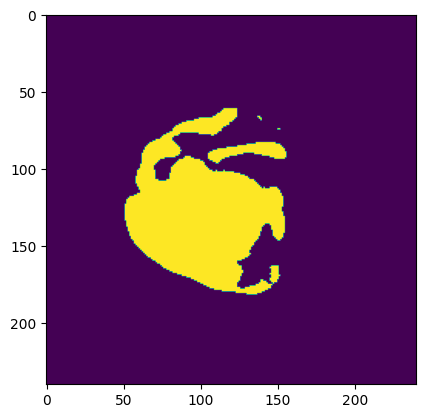

In [22]:
unet_pred=unet_model(np.expand_dims(X_test[0],0))
plt.imshow(np.argmax(unet_pred[0], axis=-1))
plt.show()


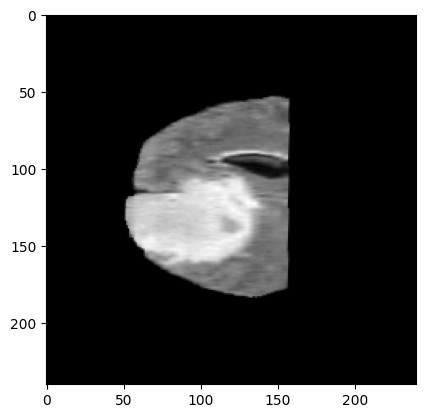

In [23]:
plt.imshow(X_test[0])
plt.show()

In [24]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice 

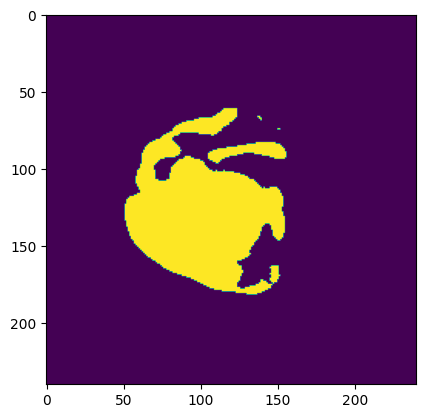

In [25]:
unet_preds=unet_model(X_test[0:50])
plt.imshow(np.argmax(unet_pred[0], axis=-1))
plt.show()

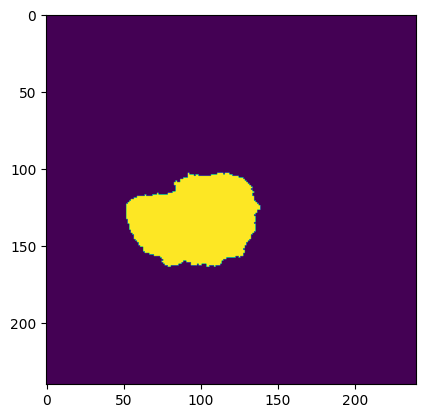

In [26]:
plt.imshow(test_masks_array[0])

In [27]:
dice_scores=[]

In [28]:
np.argmax(unet_pred[0], axis=-1).shape

(240, 240)

In [29]:
test_masks_array[0].reshape((240,240))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
for i in range(50):
    print(i)
    
    dice=DICE_COE(np.argmax(unet_preds[i], axis=-1),test_masks_array[i].reshape((240,240)))
    dice_scores.append(dice)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [31]:
dice_scores

[0.701,
 0.443,
 0.641,
 0.249,
 0.646,
 0.345,
 0.44,
 0.347,
 0.847,
 0.348,
 0.236,
 0.131,
 0.216,
 0.402,
 0.901,
 0.418,
 0.399,
 0.294,
 0.44,
 0.348,
 0.297,
 0.28,
 0.316,
 0.211,
 0.197,
 0.677,
 0.624,
 0.714,
 0.403,
 0.635,
 0.279,
 0.54,
 0.366,
 0.878,
 0.581,
 0.426,
 0.48,
 0.164,
 0.614,
 0.276,
 0.333,
 0.439,
 0.223,
 0.347,
 0.329,
 0.376,
 0.805,
 0.156,
 0.178,
 0.389]

(array([ 5.,  8., 10.,  8.,  5.,  2.,  5.,  3.,  1.,  3.]),
 array([0.131, 0.208, 0.285, 0.362, 0.439, 0.516, 0.593, 0.67 , 0.747,
        0.824, 0.901]),
 <BarContainer object of 10 artists>)

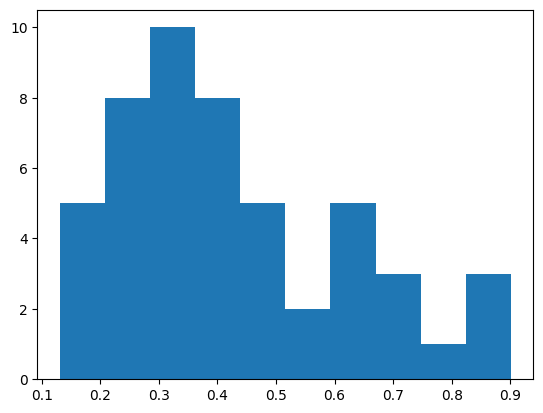

In [32]:
plt.hist(dice_scores)

In [33]:
unet_model.save_weights('unet_model_weights_250_200')

In [34]:
import pandas as pd
df=pd.DataFrame(dice_scores)
df.to_csv('Unet_Model_Dice_Scores_250_200.csv')